# NLIW depression flux calculations
### Testing to develop better functions for paper submission

In [1]:
import os
import glob
import numpy as np
import xarray as xr
import cmocean.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from d2spike.utils import nan_gauss_xr

import seaborn as sns
from wootils.plotnice import saveagu, vert_stack, plot_align, basic_ts, plot_axislabels

import sys
sys.path.insert(0, '../')
# from chp3_plotfuncs import *
from chp3_fluxfuncs import get_nliw_times, calc_flux, get_nliw_fronts, calc_settling, sample_fluxterms, reynolds_decomp
from chp3_basefuncs import load_c, load_ntu, rotate_event, rotate_data
# from chp3_paperplots import plot_papersetup, plot_paperflux, plot_paperprofiles, plot_appsummary
from chp3_samplefuncs import sample_loop_ssc

sns.set()
sns.set_style("white")
sns.set_style("ticks")
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
# sudo mount -t drvfs '\\drive.irds.uwa.edu.au\OGS-ODFDA-001' /mnt/share

pyODAS not found, not importing pIMOS.xrwrap.rsi_vmp


In [2]:
field_trip = 'RS2019'
wave_type = 'NLIW'
temp_file = 'RowleyShoals_Gridded_Mooring_T_SBE56.nc'
land_temp = 'RowleyShoals_L150_SBE56Data.nc'
moor = 'T150'

In [3]:
# Set key data directories and outputs
project_root = r'/mnt/c/Users/00099894/Large_Data/Experiments'
work_dir = r'/mnt/c/Users/00099894/OneDrive - The University of Western Australia/UWA/PhD'
load_dir = os.path.join(project_root, field_trip, wave_type)

fig_dir = f'{wave_type}_figures'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

## Load the data for event 5

In [4]:
# Load temp data
temp_nc = os.path.join(project_root, field_trip, temp_file)
ds_temp = xr.open_dataset(temp_nc, group=moor)
ds_temp.close()

# Load lander temp data
land_nc = os.path.join(project_root, field_trip, land_temp)
ds_land = xr.open_dataset(land_nc, group='L150_SBE56_T__881')
ds_land.close()

sig_file = 'SIG_meandataENU.nc'
sug_full = os.path.join('../0_identify_despike_save', sig_file)
ds_sig = xr.open_dataset(sug_full)
# echo_dp = xr.DataArray(data=ds_sig['echo'].values[:,np.newaxis], dims=['time', 'height'],\
#                        coords={'time': ds_sig['echo'].time, 'height': [5.0]})
# sig_mean_ssc = load_c(echo_dp, ds_temp, os.path.join(work_dir, 'pl'), field_trip)

ds_l_ntu = load_ntu(work_dir, '0360_burstmedian', mooring='L150')
ds_l_ntu = ds_l_ntu.rename({'Datenum':'time'})
ssc_good = (ds_l_ntu*2.62 - 4.38)/2.33

ds_h_ntu = load_ntu(work_dir, '0359_burstmedian', mooring='L150')
ssc_uppp = (ds_h_ntu*2.52 - 3.95)/2.33

In [5]:
wav_tx = get_nliw_times()
wav_fronts = get_nliw_fronts()

# c_wave = 0.6
cb_labels = ['$\\overline{C_t}$', '$\overline{W} \\times \overline{C}_z$', '$\overline{w\'c\'}_z$',\
                '$\overline{U} \\times \overline{C}_x$']

ylim = (2.4, 7.4)
# pltgf_z, pltgf_t = 4, 30
n_samp = 5
flx_bar = 0.149
gf_h, gf_t = 4, 300
thin_v, thin_t = 2, 10

In [6]:
from scipy.signal import find_peaks
def get_nliw_peaks(mode1_amp, distance=5*60/2.5):
    peaks, _ = find_peaks(mode1_amp, distance=distance)
    return peaks

def get_peak_u(u_mean, lims=[None,None]):
    u_mean_adj = u_mean.sel(time=slice(lims[0], lims[1]))
    u_ix = np.argmax(np.abs(u_mean_adj.values))
    return np.where(u_mean['time'].values == u_mean_adj['time'].values[u_ix])[0][0]

# def get_inst_peak(int_data_xr, lims=[None,None]):
#     int_data_adj = int_data_xr.sel(time=slice(lims[0], lims[1]))
#     int_ix = np.argmax(np.abs(int_data_adj.values))
#     return np.where(int_data_xr == int_data_adj[int_ix])[0][0]

def get_sig_peaks(sig_data, lims=[None,None], hlims=[None,None]):
    tx = (sig_data.time >= lims[0]) & (sig_data.time <= lims[1])
    c_mean_crop = sig_data.isel(time=tx).sel(height=slice(hlims[0], hlims[1]))
    c_imax = np.nanargmax(c_mean_crop.values, axis=1)
    c_time = np.array([c_mean_crop.time.values[x] for x in c_imax], dtype='datetime64')
    # Nan times where not monotonically increasing
    # c_time[:-1][np.diff(c_time) < np.timedelta64(0,'ns')] = np.datetime64('NaT')
    return c_time

In [7]:
def get_adv_peaks(lims=[None,None]):
    # Load each ADV and extract max backscatter
    adv_files = glob.glob(os.path.join(r'/mnt/share/Experiments/rs19/archive_FV01/Nortek Vector/', '*.nc'))
    adv_sn = ['6019', '6017', '6329']
    adv_time = []
    adv_height = []

    for sn in adv_sn:
        adv_file = [f for f in adv_files if sn in f]
        for file in adv_file:
            ds_adv = xr.open_dataset(file)
            ds_adv.close()

            # Check if contains wave period
            if (ds_adv.time.values[0] < lims[0]) & \
                (ds_adv.time.values[-1] > lims[0]):
                print(f'Found {sn} in {file}')
            
                # Find the index of peak backscatter
                adv_tx = (ds_adv.time.values > lims[0]) & \
                        (ds_adv.time.values < lims[1])
                adv_echo = nan_gauss_xr(ds_adv['echo'].isel(beam=0)[adv_tx]/100, 75*64)
                adv_ix = np.argmax(adv_echo.values)
                adv_time.append(ds_adv.time.values[adv_tx][adv_ix])
                adv_height.append(ds_adv.attrs['nominal_instrument_height_asb'])
                break
    return adv_time, adv_height

In [8]:
def plot_papersetup(u_mean, w_mean, ds_temp, u_full, w_full, c_full, land_temp, ssc_good, ssc_uppp, sig_mean_ssc,\
                    ulinemin=0.89, wtick=0.1, umin=0.79, wmin=0.149, cmin=49):
    h_rat = [1,3,2,2,2,1]
    fig, ax = vert_stack(6, hsize=8, vsize=7/6, hspace=0.1, h_ratio=h_rat)
    par = ax[0].twinx()
    # par2 = ax[5].twinx()
    axf = np.append(ax, par).flatten()

    # Plot mean U and W at single height
    u_mean.plot(ax=ax[0], c='k', linewidth=1.5)
    w_mean.plot(ax=par, c='r', linewidth=1.5)
    ax[0].set_ylabel('$\overline{U}$\n[m s$^{-1}$]')
    ax[0].set_ylim(-ulinemin, ulinemin)
    par.set_ylabel('$\overline{W}$\n[m s$^{-1}$]')
    par.yaxis.label.set_color('red')
    par.tick_params(axis='y', colors='red')
    par.set_ylim(-wtick*(ulinemin/0.5), wtick*(ulinemin/0.5))

    # Plot temperature
    ds_temp.plot.contourf(ax=ax[1], cmap=plt.cm.viridis, levels=np.arange(18,31,1),\
                          cbar_kwargs={'pad':0.01, 'label':'Temperature\n[$^\circ$C]'})
    ds_temp.plot.contour(ax=ax[1], colors='k', linewidths=0.1,\
                         levels=np.arange(18,31,1), add_colorbar=False)

    # Plot U
    u_full.plot(ax=ax[2], cmap='PuOr', vmin=-umin, vmax=umin,\
                cbar_kwargs={'pad': 0.01, 'label': '$U$ [m s$^{-1}$]'})

    # Plot W
    w_full.plot(ax=ax[3], cmap=cm.balance, vmin=-wmin, vmax=wmin,\
                cbar_kwargs={'pad': 0.01, 'label': '$W$ [m s$^{-1}$]'})

    # Plot C
    ax[4].fill_between(c_full.time, 0.5, 1.5, color='grey', alpha=1)
    c_full.plot(ax=ax[4], cmap=cm.turbid, vmin=0, vmax=cmin,\
                cbar_kwargs={'pad': 0.01, 'label': 'C\n[g m$^{-3}$]'})
    ax[4].fill_between(c_full.time, 0.5, 0.9, color='grey', alpha=1)

    # Line plots
    # land_temp.plot(ax=ax[5], c='blue', linewidth=1.5)
    sig_mean_ssc.plot(ax=ax[5], c='grey', linewidth=1.5)
    ssc_uppp.plot(ax=ax[5], c='k', linestyle=':', linewidth=1.5)
    ssc_good.plot(ax=ax[5], c='k', linewidth=1.5)
    ax[5].set_ylim(0, 120)
    ax[5].set_xlabel('')
    # ax[5].yaxis.label.set_color('blue')
    # ax[5].tick_params(axis='y', colors='blue')
    # ax[5].set_ylabel('T [$^\circ$C]\n0.3 mab')
    ax[5].set_ylabel('C\n[g m$^{-3}$]')

    #####################
    plot_align(axf)
    basic_ts(u_mean.time.values, axf)

    for xiax, x in enumerate(ax):
        if (xiax > 0) & (xiax < 5):
            x.set_ylabel('m ASB')

    myFmt = mdates.DateFormatter('%H:%M')
    ax[5].xaxis.set_major_formatter(myFmt)
    plot_axislabels(ax, pos='topleft', h_ratios=h_rat)
    ax[0].grid()
    return fig, ax

In [9]:
def plot_c_lag(ds, ntu, ii):
    # Get the NLIW peaks
    m1_pks = get_nliw_peaks(ds['mode_1'])

    # Get the NLIW troughs
    m1_troughs = get_nliw_peaks(-ds['mode_1'])

    # Get the peak u
    peak_u = get_peak_u(ds['u_mean'].sel(height=5.02), lims=[ds['time'].values[m1_troughs[0]], ds['time'].values[m1_pks[1]]])

    # Get the peak C from all relevant instruments
    adv_time, adv_height = get_adv_peaks(lims=[ds['time'].values[m1_troughs[0]], ds['time'].values[m1_troughs[1]]])

    # Get the peak C from the NTU
    ntu_time = ssc_good['time'][get_inst_peak(ssc_good, lims=[ds['time'].values[m1_troughs[0]], ds['time'].values[m1_troughs[1]]])]

    # Get the peak C from the Sig
    c_time = get_sig_peaks(ds['c_mean'], lims=[ds['time'].values[m1_troughs[0]], ds['time'].values[m1_troughs[1]]],
                                hlims=[1.75, 5.5])

    fig, ax = plt.subplots(1,1, figsize=(12, 4))
    ds['c_mean'][::2,::2].plot(cmap=cm.turbid)

    plt.plot(ds.time.values, 8.5 + ds['mode_1']/20, c='k')
    plt.scatter(ds.time.values[m1_pks], 8.5 + ds['mode_1'].isel(time=m1_pks)/20, c='r')
    plt.scatter(ds.time.values[m1_troughs], 8.5 + ds['mode_1'].isel(time=m1_troughs)/20, c='b')
    plt.scatter(ds.time.values[peak_u], 8.5 + ds['mode_1'].isel(time=peak_u)/20, c='g')

    plt.scatter(c_time, ds.height.sel(height=slice(1.75,5.5)), c='orange', s=15)
    plt.scatter(adv_time, adv_height, c='purple', s=15)
    plt.scatter(ntu_time, 0.35, c='yellow', s=15)

    plt.xlim(ds.time.values[100], ds.time.values[1700])
    plt.ylim(0, 10)
    plt.title(f'Wave {ii}')
    return fig, ax

In [10]:
# Load wave data
for ii, (wt, wf) in enumerate(zip(wav_tx, wav_fronts)):
    if (ii == 7):
    
        # Load fluxes
        sig_fil = f'{wave_type}_E{int(ii+1)}_fluxattrs.nc'
        vel_file = os.path.join(load_dir, sig_fil)
        ds = xr.open_dataset(vel_file)
        xr.Dataset.close(ds)
        print(f'Loaded {sig_fil}')    

        start = np.timedelta64(5, 'm')
        end = (2*(ds.time.values[-1] - ds.time.values[0])/3).astype('timedelta64[ns]')

        tx_sig = (ds.time.values >= ds.time.values[0] + start) &\
                    (ds.time.values <= ds.time.values[0] + end)
                   
        u_r_mean = ds['u_mean'].sel(height=5.02).isel(time=tx_sig)

Loaded NLIW_E8_fluxattrs.nc


In [11]:
sett = 0.000

new_u = np.full_like(ds['u_mean'].values, np.nan)
new_w = np.full_like(ds['u_mean'].values, np.nan)

for ii, hh in enumerate(ds.height):
    # pca_BT = PCA_2D(ds['u_mean'].sel(height=hh), ds['w_mean'].sel(height=hh))
    # new_u[ii,:], new_w[ii,:] = rotate_2D(ds['u_mean'].sel(height=hh), ds['w_mean'].sel(height=hh), -pca_BT[0])
    new_w[ii,:] = ds['w_mean'].sel(height=hh).values - ds['w_mean'].sel(height=hh).mean().values - sett


In [12]:
# ds['u_mean'] = xr.DataArray(new_u, dims=['height', 'time'], coords={'height': ds.height, 'time': ds.time})
ds['w_mean'] = xr.DataArray(new_w, dims=['height', 'time'], coords={'height': ds.height, 'time': ds.time})

In [13]:
# Get the NLIW peaks
m1_pks = get_nliw_peaks(ds['mode_1'], distance=5*60)

# Get the NLIW troughs
m1_troughs = get_nliw_peaks(-ds['mode_1'], distance=5*60)

pk = 2
tg = 1

# 0: # pk=3, tg=2
# 1: # pk=1, tg=0
# 2: # pk=1, tg=0
# 3: # pk=1, tg=0
# 4: # pk=1, tg=0
# 5: # pk=1, tg=0
# 6: # pk=2, tg=1
# 7: # pk=2, tg=1
# 8: NaN
# 9: NaN
# 10: pk=3, tg=2
# 11: NaN

# Get the peak u
peak_u = get_peak_u(ds['u_mean'].sel(height=5.02), lims=[ds['time'].values[m1_troughs[tg]], ds['time'].values[m1_pks[pk]]])

# Get the peak C from all relevant instruments
adv_time, adv_height = get_adv_peaks(lims=[ds['time'].values[m1_pks[pk-1]], ds['time'].values[m1_pks[pk]] + np.timedelta64(5, 'm')])

# Get the peak C from the NTU
ntu_time = ssc_good['time'][get_peak_u(ssc_good, lims=[ds['time'].values[m1_pks[pk-1]], ds['time'].values[m1_pks[pk]]])]

# Get the peak C from the Sig
c_time = get_sig_peaks(ds['c_mean'], lims=[ds['time'][peak_u].values, ds['time'].values[m1_pks[pk]] + np.timedelta64(15, 'm')],
                        hlims=[1.15, 5.5])

Found 6019 in /mnt/share/Experiments/rs19/archive_FV01/Nortek Vector/[RS2019]_[RS19_REC]_[L150]_[128]_[Nortek Vector]_[6019]_[2of4].nc
Found 6017 in /mnt/share/Experiments/rs19/archive_FV01/Nortek Vector/[RS2019]_[RS19_REC]_[L150]_[59]_[Nortek Vector]_[6017]_[2of3].nc
Found 6329 in /mnt/share/Experiments/rs19/archive_FV01/Nortek Vector/[RS2019]_[RS19_REC]_[L150]_[81]_[Nortek Vector]_[6329]_[2of4].nc


In [14]:
# ssc_good.sel(time=slice(ds['time'].values[m1_pks[pk-1]], ds['time'].values[m1_pks[pk]])).plot()

(0.0, 10.0)

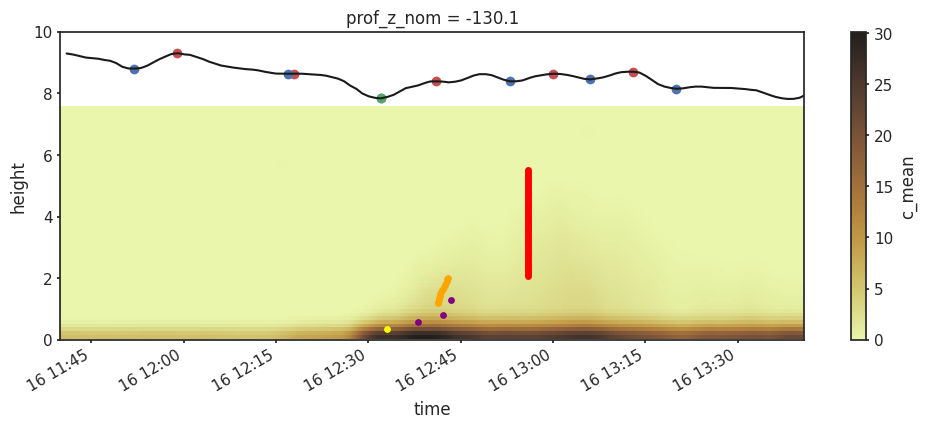

In [15]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))
ds['c_mean'][::2,::2].plot(cmap=cm.turbid)

plt.plot(ds.time.values, 8.5 + ds['mode_1']/20, c='k')
plt.scatter(ds.time.values[m1_pks], 8.5 + ds['mode_1'].isel(time=m1_pks)/20, c='r')
plt.scatter(ds.time.values[m1_troughs], 8.5 + ds['mode_1'].isel(time=m1_troughs)/20, c='b')
plt.scatter(ds.time.values[peak_u], 8.5 + ds['mode_1'].isel(time=peak_u)/20, c='g')

plt.scatter(c_time, ds.height.sel(height=slice(1.15,5.5)), c='orange', s=15)
ix = ds.height.sel(height=slice(1.15,5.5)) > 2.05
plt.scatter(c_time[ix], ds.height.sel(height=slice(1.15,5.5))[ix], c='red', s=15)

plt.scatter(adv_time, adv_height, c='purple', s=15)
plt.scatter(ntu_time, 0.35, c='yellow', s=15)

plt.xlim(ds.time.values[0], ds.time.values[2900])
plt.ylim(0, 10)

In [16]:
# Set the end of the first wave
wv_t = ds.time.values[m1_pks[pk]] 

######
wave_sel = wv_t
tx = ds.time.values[tx_sig] < wave_sel + np.timedelta64(8, 'm')

# Find the peak currents under the first wave
mwave_xx = np.argmin(u_r_mean.values[tx])

# Find the next intersection of W with zero
w_r_mean =ds['w_mean'].sel(height=5.02).isel(time=tx_sig)
zero_w = np.where(w_r_mean.values[tx][(mwave_xx+30):] < 0)[0][0] # sloppy

In [17]:
time = u_r_mean.time[tx][mwave_xx:][:zero_w+200]
c_mean_crop = ds['c_mean'].sel(time=time.values, height=slice(1.15, 5.5))
# c_mean_crop.plot(cmap=cm.turbid)

In [18]:
def scale_time(time, scale, origin=u_r_mean.time[tx][mwave_xx].values):
    time_sec = (time - origin).astype('timedelta64[s]').astype('float')
    scale_sec = scale / np.timedelta64(1,'s')
    return time_sec / scale_sec

In [19]:
scale_h = 150 / 100
scale_w = 2 * (ds.time.values[m1_pks][pk] - ds.time.values[peak_u])

In [20]:
ds_peaks = xr.Dataset()
ds_peaks['adv'] = xr.DataArray(np.array(adv_height) / scale_h, dims=['time_adv'], coords={'time_adv': scale_time(adv_time, scale_w)})
ds_peaks['ntu'] = xr.DataArray(np.array(0.35 / scale_h)[None], dims=['time_ntu'], coords={'time_ntu': np.array(scale_time(ntu_time.values, scale_w))[None]})
ds_peaks['sig'] = xr.DataArray(c_mean_crop.height.values[~ix] / scale_h, dims=['time_sig'], coords={'time_sig': scale_time(np.array(c_time)[~ix], scale_w)})
ds_peaks.attrs['scale_h'] = scale_h
ds_peaks.attrs['scale_w'] = scale_w / np.timedelta64(1,'s')

ds_peaks.to_netcdf(os.path.join('nliw_peaks', sig_fil.replace('fluxattrs', 'peaks')))
ds_peaks

<xarray.Dataset>
Dimensions:   (time_adv: 3, time_ntu: 1, time_sig: 15)
Coordinates:
  * time_adv  (time_adv) float64 0.638 0.3324 0.5583
  * time_ntu  (time_ntu) float64 0.05648
  * time_sig  (time_sig) float64 0.5139 0.5204 0.5231 ... 0.5972 0.6019 0.6083
Data variables:
    adv       (time_adv) float64 0.8533 0.3933 0.54
    ntu       (time_ntu) float64 0.2333
    sig       (time_sig) float64 0.7867 0.8267 0.8667 ... 1.267 1.307 1.347
Attributes:
    scale_h:  1.5
    scale_w:  1080.00101

Text(0, 0.5, 'H [%]')

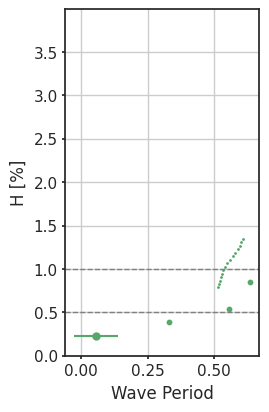

In [21]:
fig, ax = plt.subplots(1,1, figsize=(2.5, 4.5))

# Plot from ds_peaks
ax.axhline(0.5, c='grey', ls='--', lw=1)
ax.axhline(1, c='grey', ls='--', lw=1)

ax.scatter(ds_peaks['time_adv'], ds_peaks['adv'], c='g', s=10)

ntu_err_sc = 90 / ds_peaks.attrs['scale_w']
ax.errorbar(ds_peaks['time_ntu'], ds_peaks['ntu'], xerr=ntu_err_sc, c='g', marker='o', markersize=5)
ax.scatter(ds_peaks['time_sig'], ds_peaks['sig'], c='g', s=1)

plt.ylim(0, 3.99)
plt.xticks([0,0.25,0.5])
plt.grid()
plt.title('')
plt.xlabel('Wave Period')
plt.ylabel('H [%]')

In [22]:
# fig, ax = plt.subplots(1,1, figsize=(2.5, 4.5))

# # Find the index of the peak C in each bin
# # c_imax = np.argmax(c_mean_crop.values, axis=1)
# # c_time = [c_mean_crop.time.values[x] for x in c_imax]
# c_time_sc = scale_time(np.array(c_time), scale_w)

# ax.axhline(0.5, c='grey', ls='--', lw=1)
# ax.axhline(1, c='grey', ls='--', lw=1)
# # ax.axvline(0, c='k', ls='--', lw=1)
# # ax.axvline(0.5, c='k', ls='--', lw=1)

# plt.scatter(c_time_sc[~ix], ds.height.sel(height=slice(1.15,5.5)).values[~ix] / scale_h, c='g', s=1)

# ntu_err_sc = np.timedelta64(90,'s') / scale_w
# plt.errorbar(scale_time(ntu_time.values, scale_w), 0.35/scale_h,
#              xerr=ntu_err_sc, c='g', marker='o', markersize=5)

# # plt.scatter(scale_time(adv_time, scale_w), np.array(adv_height) / scale_h, c='g', s=10)
# plt.ylim(0, 3.99)
# plt.xticks([0,0.25,0.5])
# plt.grid()
# plt.title('')
# plt.xlabel('Wave Period')
# plt.ylabel('H [%]')
# # saveagu(os.path.join(fig_dir, f'{wave_type}_E{int(ii+1)}_peakcomp_f1v2'), fig)

<!-- # Load all events and plot -->

In [23]:
import pandas as pd
df_dir = os.path.join('../', '7_event_comparisons', 'NLIW_figures')
df_all = pd.read_csv(os.path.join(df_dir, 'NLIW_fluxes.csv'))
df_all.drop(columns=['Unnamed: 0'], inplace=True)
df_all.head()

,$\overline{C}_{max}$,$\overline{U}^2_{max}$,$\overline{W}_{max}$,$\overline{w'w'}_{max}$,$\overline{w'c'}_{max}$,$S_{est}$,$L_W$,$-ka$,$R_{ISW}$,$-A_1$
0,4.927237,0.280883,0.006950,0.415347,0.012717,0.275600,192.009772,0.055779,3549.403640,21.420269
1,23.472021,0.508291,0.011197,0.576633,0.055941,0.297947,261.162074,0.031321,5216.002314,16.359854
2,19.102987,0.457425,0.007725,0.511892,0.039496,0.358915,324.794352,0.062857,4908.691238,40.831370
3,10.217449,0.204658,0.007090,0.603421,0.026897,0.275461,358.549004,0.047330,5484.189425,33.940520
4,9.481300,0.348694,0.007427,0.385152,0.017403,0.315808,267.057956,0.033966,4791.898223,18.141672


Loaded NLIW_E1_peaks.nc
Loaded NLIW_E2_peaks.nc
Loaded NLIW_E3_peaks.nc
Loaded NLIW_E4_peaks.nc
Loaded NLIW_E5_peaks.nc
Loaded NLIW_E6_peaks.nc
Loaded NLIW_E7_peaks.nc
Loaded NLIW_E8_peaks.nc
Loaded NLIW_E11_peaks.nc


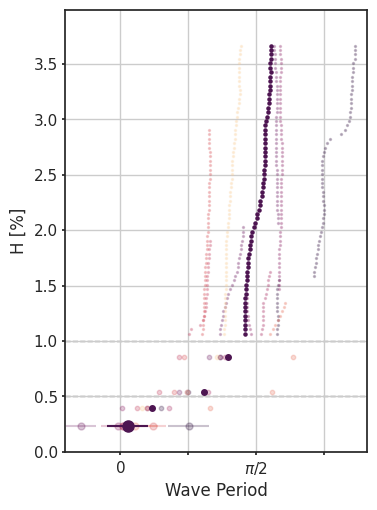

In [26]:
import wootils.plotnice as pn
import cmocean.cm as cm
col = cm.matter_r(np.linspace(0, 0.9, len(wav_tx)))

# fig, ax = plt.subplots(1,1, figsize=(2.5, 4.5))
fig, ax = pn.horz_stack(1, hsize=4, vsize=6.5)
ax = [ax]

# Move axis zero to the right
ax_zero = ax[0].get_position()
ax[0].set_position([ax_zero.x0+0.2, ax_zero.y0, ax_zero.width-0.02, ax_zero.height-0.09])

ax[0].axhline(0.5, c='grey', ls='--', lw=1, zorder=0)
ax[0].axhline(1, c='grey', ls='--', lw=1, zorder=0)
    
for ii, (wt, wf, cc) in enumerate(zip(wav_tx, wav_fronts, col)):
    if ii==1:
        alpha_plt = 1
        zord = 15
        spls = 3
    else:
        alpha_plt = 0.25
        zord = ii+1
        spls = 0
    
    # if (ii != 8) & (ii != 7):
    sig_fil = f'{wave_type}_E{int(ii+1)}_fluxattrs.nc'
    if os.path.exists(os.path.join('nliw_peaks', sig_fil.replace('fluxattrs', 'peaks'))):
        ds = xr.open_dataset(os.path.join('nliw_peaks', sig_fil.replace('fluxattrs', 'peaks')))
        print(f'Loaded {sig_fil.replace("fluxattrs", "peaks")}')
    
        # Plot ADCP peaks
        sig_ix = (ds.time_sig.values > 0.05) & (ds.time_sig.values < 0.95) & (ds.sig.values > 1.06)
        # iteratively remove times that get smaller than threshold
        thresh = -0.01
        six_tx = np.where(np.diff(ds.time_sig.values[sig_ix]) < thresh)[0]
        if len(six_tx) > 0:
            sig_ix[six_tx[0]:] = False
        ax[0].scatter(ds.time_sig.values[sig_ix], ds.sig.values[sig_ix], c=cc, s=2+spls, alpha=alpha_plt, zorder=zord)

        ntu_err_sc = 90 / ds.attrs['scale_w']
        ax[0].errorbar(ds.time_ntu, ds.ntu,
                    xerr=ntu_err_sc, c=cc, marker='o', markersize=5+spls,
                    alpha=alpha_plt, zorder=zord)

        ax[0].scatter(ds.time_adv, ds.adv, c=cc, s=10+2*spls, alpha=alpha_plt, zorder=zord)
ax[0].set_ylim(0, 3.99)
ax[0].set_xticks([0,0.25,0.5, 0.75])
ax[0].set_xticklabels(['$0$', '', '$\pi/2$', ''])
ax[0].set_xlim(-0.2, 0.91)
ax[0].grid()
ax[0].set_title('')
ax[0].set_xlabel('Wave Period')
ax[0].set_ylabel('H [%]')    

saveagu(os.path.join(fig_dir, f'{wave_type}_lagprofiles_f4v1'), fig)

Loaded NLIW_E1_peaks.nc
Loaded NLIW_E2_peaks.nc
Loaded NLIW_E3_peaks.nc
Loaded NLIW_E4_peaks.nc
Loaded NLIW_E5_peaks.nc
Loaded NLIW_E6_peaks.nc
Loaded NLIW_E7_peaks.nc
Loaded NLIW_E8_peaks.nc
Loaded NLIW_E11_peaks.nc


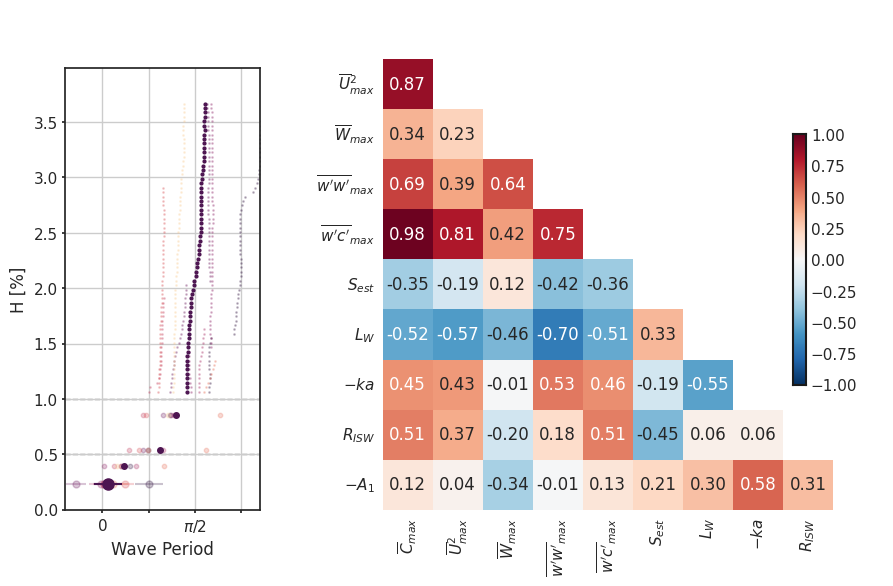

In [25]:
import wootils.plotnice as pn
import cmocean.cm as cm
col = cm.matter_r(np.linspace(0, 0.9, len(wav_tx)))

# fig, ax = plt.subplots(1,1, figsize=(2.5, 4.5))
fig, ax = pn.horz_stack(2, hsize=15, vsize=6.5, w_ratio=[1,4])

# Move axis zero to the right
ax_zero = ax[0].get_position()
ax[0].set_position([ax_zero.x0+0.2, ax_zero.y0, ax_zero.width-0.02, ax_zero.height-0.09])

ax[0].axhline(0.5, c='grey', ls='--', lw=1, zorder=0)
ax[0].axhline(1, c='grey', ls='--', lw=1, zorder=0)
    
for ii, (wt, wf, cc) in enumerate(zip(wav_tx, wav_fronts, col)):
    if ii==1:
        alpha_plt = 1
        zord = 15
        spls = 3
    else:
        alpha_plt = 0.25
        zord = ii+1
        spls = 0
    
    # if (ii != 8) & (ii != 7):
    sig_fil = f'{wave_type}_E{int(ii+1)}_fluxattrs.nc'
    if os.path.exists(os.path.join('nliw_peaks', sig_fil.replace('fluxattrs', 'peaks'))):
        ds = xr.open_dataset(os.path.join('nliw_peaks', sig_fil.replace('fluxattrs', 'peaks')))
        print(f'Loaded {sig_fil.replace("fluxattrs", "peaks")}')
    
        # Plot ADCP peaks
        sig_ix = (ds.time_sig.values > 0.05) & (ds.time_sig.values < 0.95) & (ds.sig.values > 1.06)
        # iteratively remove times that get smaller than threshold
        thresh = -0.01
        six_tx = np.where(np.diff(ds.time_sig.values[sig_ix]) < thresh)[0]
        if len(six_tx) > 0:
            sig_ix[six_tx[0]:] = False
        ax[0].scatter(ds.time_sig.values[sig_ix], ds.sig.values[sig_ix], c=cc, s=1+spls, alpha=alpha_plt, zorder=zord)

        ntu_err_sc = 90 / ds.attrs['scale_w']
        ax[0].errorbar(ds.time_ntu, ds.ntu,
                    xerr=ntu_err_sc, c=cc, marker='o', markersize=5+spls,
                    alpha=alpha_plt, zorder=zord)

        ax[0].scatter(ds.time_adv, ds.adv, c=cc, s=10+2*spls, alpha=alpha_plt, zorder=zord)
ax[0].set_ylim(0, 3.99)
ax[0].set_xticks([0,0.25,0.5, 0.75])
ax[0].set_xticklabels(['$0$', '', '$\pi/2$', ''])
ax[0].set_xlim(-0.2, 0.85)
ax[0].grid()
ax[0].set_title('')
ax[0].set_xlabel('Wave Period')
ax[0].set_ylabel('H [%]')    


outlier = 5

df_all_drop = df_all.drop([outlier], inplace=False)

# Plot a correlation heatmap of the data
corr = df_all_drop.iloc[:,:].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap='RdBu_r', vmin=-1, vmax=1, square=True, annot=True,\
            fmt='.2f', cbar_kws={"shrink": .5, 'pad':-0.1}, ax=ax[1])
cbar_ax = fig.axes[-1]

# Make ticks invisible
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True, right=False, left=False, labelleft=True)

xlabels = [item.get_text() for item in ax[1].get_xticklabels()]
xlabels[-1] = ''
ax[1].set_xticklabels(xlabels)

ylabels = [item.get_text() for item in ax[1].get_yticklabels()]
ylabels[0] = ''
ax[1].set_yticklabels(ylabels)

cbar_ax.tick_params(width=0, length=0, direction='in')
for axis in ['top','bottom','left','right']:
    cbar_ax.spines[axis].set_visible(True)
    cbar_ax.spines[axis].set_linewidth(1.5)
    cbar_ax.spines[axis].set_color('k')

# plt.tight_layout()
saveagu(os.path.join(fig_dir, f'{wave_type}_E{int(ii+1)}_combinedp_f1v1'), fig)